# Survival Analysis with Cox Model Implementation using Adaptive COVID-19 Treatment Trial (ACTT) Data 

### Data Source: [NIAID Accessing NIAID Clinical Trials Data Commons](https://accessclinicaldata.niaid.nih.gov/NIAID-ACTT)

### Related study publication: https://pubmed.ncbi.nlm.nih.gov/32445440/
### Related clinical trial: https://clinicaltrials.gov/ct2/show/NCT04280705
#### Fan Wang
#### February 2 2021

In this notebook, we explore the clinical data from Adaptive COVID-19 Treatment Trial (ACTT) to evaluate the clinical efficacy of remdesivir relative to the control arm in patients hospitalized with COVID-19 as assessed by the time to recovery. 

This notebook showcases the ability to do exploratory analysis within the NIAID Accessing NIAID Clinical Trials Data Commons. The analysis is not intended to constitute advice nor is it to be used as a substitute for decision making from a professional. The data used in this notebook is controlled access and can be shared securely by granting the users access to this data in the NIAID Clinical Trials Data Commons.


## Table of contents
1. Study design and data description.

2. Demographic and clinical characteristics of the patients at baseline.

3. Kaplan–Meier estimates of cumulative recoveries.

4. Recovery rate ratios and hazard ratios calculated from the stratified Cox model.

***

## Study design and data description

### 1. Study design 
ACTT-1 (Adaptive COVID-19 Treatment Trial) is an adaptive, randomized, double-blind, placebo-controlled trial to evaluate the safety and efficacy of remdesivir (200 mg loading dose on day 1, followed by 100 mg daily for up to
9 additional days) in hospitalized adults diagnosed with COVID-19. Subjects will be assessed daily while hospitalized. If the subjects are discharged from the hospital, they will have a study visit at Days 15, 22, and 29. 

The primary outcome is time to recovery by Day 29. The primary analysis will include data from both severity groups using a stratified log-rank test. A key secondary outcome evaluates treatment-related improvements in the 8-point ordinal scale at Day 15. As little is known about the clinical course of COVID-19, an evaluation of the pooled (i.e., blinded to treatment assignment) proportion recovered will be used to gauge whether the targeted total number of
subjects in the recovered categories of the ordinal scale will be achieved with the planned sample size. The analysis of the pilot data will be blinded, allowing for the pilot data to be included in subsequent analyses. 

### 2. Import packages
We’ll first import all the packages that we need for this notebook:
* `numpy` is the fundamental package for scientific computing in python.
* `pandas` is what we’ll use to manipulate our data.
* `matplotlib` is a plotting library.
* `tableone` is a package for creating summary statistics for a patient population.
* `lifelines` is an open-source survival analysis library.

In [1]:
# ! pip install tableone
# ! pip install --upgrade scipy
# ! pip install --upgrade lifelines
# ! pip install patsy==0.5.1
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from tableone import TableOne, load_dataset
import matplotlib.pyplot as plt
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from patsy import dmatrices
from scipy import stats
import string

Load the Dataset:

In [2]:
data = pd.read_csv("ACTT1.csv")
data.head()

,USUBJID,TRTP,AGE,SEX,RACE,ETHNIC,BMI,REGION,STRATUM,ORDSCRG,...,CANCERFL,IMMDFL,ASTHMAFL,COMORB1,COMORB2,ORDSCR15,TTRECOV,RECCNSR,TTDEATH,DTHCNSR
0,COV.00701,Placebo,74,M,ASIAN,NOT HISPANIC OR LATINO,NaN,North America,Severe Disease,Baseline Clinical Status Score 5,...,N,N,N,No Comorbidities,No Comorbidities,1,5,0,26,1
1,COV.00702,Remdesivir,80,M,WHITE,NOT HISPANIC OR LATINO,NaN,North America,Severe Disease,Baseline Clinical Status Score 5,...,N,N,N,Any Comorbidities,1 Comorbidity,2,6,0,28,1
2,COV.00703,Placebo,36,F,WHITE,NOT HISPANIC OR LATINO,40.7,North America,Severe Disease,Baseline Clinical Status Score 7,...,N,N,Y,Any Comorbidities,2 or more Comorbidities,7,25,1,26,1
3,COV.00704,Placebo,75,F,WHITE,NOT HISPANIC OR LATINO,27.6,North America,Severe Disease,Baseline Clinical Status Score 6,...,N,N,N,Any Comorbidities,1 Comorbidity,2,11,0,27,1
4,COV.00705,Placebo,62,F,WHITE,NOT HISPANIC OR LATINO,32.5,North America,Severe Disease,Baseline Clinical Status Score 6,...,N,N,N,Any Comorbidities,2 or more Comorbidities,5,26,0,28,1


### 3. Data description 


#### Demographic characteristics:
* `USUBJID`: Subject ID.
* `TRTP`: Treatment group.
* `AGE`: Age (<40; 40-64; 65 and older). 
* `SEX`: Sex (Female; Male).
* `RACE`: Race (White; Black/African American; Asian; Other).
* `ETHNIC`: Ethnic.
* `BMI`: BMI.
* `REGION`: Geographic region (North American sites; Asian sites; European sites).
* `STRATUM`: Disease severity. "Severe disease" was defined as participants meeting one or more of the following criteria: requiring invasive or non-invasive mechanical ventilation, requiring supplemental oxygen, an SpO2 ≤ 94% on room air, or tachypnea (respiratory rate ≥ 24 breaths per minute). "Mild / moderate disease" was defined by a SpO2 > 94% and respiratory rate < 24 breaths per minute without supplemental oxygen requirement.
* `ORDSCRG`: Baseline ordinal scale category (4; 5; 6; 7). 
* `BDURSYMP`: Duration of symptoms prior to enrollment.


#### Prior and concurrent medical conditions:
* `HYPFL`: Hypertension.
* `CADFL`: Coronary artery disease.	
* `CHFFL`: Congestive heart failure.	
* `CRDFL`: Chronic respiratory disease.	
* `CORFL`: Chronic oxygen requirement.	
* `CLDFL`: Chronic liver disease	
* `CKDFL`: Chronic kidney disease.	
* `DIAB1FL`: Diabetes I.
* `DIAB2FL`: Diabetes II.
* `OBESIFL`: Obesity.
* `CANCERFL`: Cancer.	
* `IMMDFL`: Immune deficiency.	
* `ASTHMAFL`: Asthma.	
* `COMORB1`: Comorbidity presence (None; Any).
* `COMORB2`: Comorbidity number (None, One, Two or more).


#### Baseline characteristics:
* `STRATUM`: Disease severity. "Severe disease" was defined as participants meeting one or more of the following criteria: requiring invasive or non-invasive mechanical ventilation, requiring supplemental oxygen, an SpO2 ≤ 94% on room air, or tachypnea (respiratory rate ≥ 24 breaths per minute). "Mild / moderate disease" was defined by a SpO2 > 94% and respiratory rate < 24 breaths per minute without supplemental oxygen requirement.
* `ORDSCRG`: Baseline ordinal scale category (4; 5; 6; 7). 
* `BDURSYMP`: Duration of symptoms prior to enrollment.
* `ORDSCR15`: The 8-point ordinal clinical status scale at Day 15.


#### Primary measures:
* `TTRECOV`: Time to recovery.
* `RECCNSR`: Recovery censored.
* `TTDEATH`: Time to death.
* `DTHCNSR`: Death censored.

## Demographic and Baseline Characteristics by Treatment Group 
Subject screening will begin with a brief discussion with study staff. Some will be excluded based on demographic data and medical history (i.e., pregnant, < 18 years of age, renal failure, etc.). In order to be eligible to participate in this study, a patient must meet all of the required criteria. Please find the additional study procedures details [Here](https://clinicaltrials.gov/ProvidedDocs/05/NCT04280705/Prot_001.pdf).

In the below table, summaries of age, sex, race, ethnicity, comorbidity and baseline clinical status score is presented by treatment groups.

In [3]:
columns = [
    "AGE",
    "SEX",
    "RACE",
    "ETHNIC",
    "COMORB2",
    "DIAB2FL",
    "HYPFL",
    "OBESIFL",
    "ORDSCRG",
]
categorical = [
    "SEX",
    "RACE",
    "ETHNIC",
    "COMORB2",
    "DIAB2FL",
    "HYPFL",
    "OBESIFL",
    "ORDSCRG",
]
groupby = ["TRTP"]
labels = {
    "AGE": "Age",
    "SEX": "Sex",
    "RACE": "Race",
    "ETHNIC": "Ethnic group",
    "COMORB2": "No. of coexisting conditions",
    "DIAB2FL": "Type 2 diabetes",
    "HYPFL": "Hypertension",
    "OBESIFL": "Obesity",
    "ORDSCRG": "Score on ordinal scale",
}
mytable = TableOne(
    data,
    columns=columns,
    categorical=categorical,
    groupby=groupby,
    rename=labels,
    pval=False,
)
mytable

Grouped by TRTP                                       
                                                                                      Missing      Overall      Placebo   Remdesivir
n                                                                                                     1062          521          541
Age, mean (SD)                                                                              0  58.9 (15.0)  59.2 (15.4)  58.6 (14.6)
Sex, n (%)                          F                                                       0   378 (35.6)   189 (36.3)   189 (34.9)
                                    M                                                           684 (64.4)   332 (63.7)   352 (65.1)
Race, n (%)                         AMERICAN INDIAN OR ALASKA NATIVE                        0      7 (0.7)      3 (0.6)      4 (0.7)
                                    ASIAN                                                       135 (12.7)    56 (10.7)    79 (14.6)
                                    BLACK OR AFRICAN AMERICAN                                   226 (21.3)   117 (22.5)   109 (20.1)
                                    MULTIPLE                                                       3 (0.3)      1 (0.2)      2 (0.4)
                                    NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                      4 (0.4)      2 (0.4)      2 (0.4)
                                    UNKNOWN                                                     121 (11.4)    55 (10.6)    66 (12.2)
                                    WHITE                                                       566 (53.3)   287 (55.1)   279 (51.6)
Ethnic group, n (%)                 HISPANIC OR LATINO                                      0   250 (23.5)   116 (22.3)   134 (24.8)
                                    NOT HISPANIC OR LATINO                                      755 (71.1)   373 (71.6)   382 (70.6)
                                    NOT REPORTED                                                  29 (2.7)     14 (2.7)     15 (2.8)
                                    UNKNOWN                                                       28 (2.6)     18 (3.5)     10 (1.8)
No. of coexisting conditions, n (%) 1 Comorbidity                                           0   275 (25.9)   137 (26.3)   138 (25.5)
                                    2 or more Comorbidities                                     579 (54.5)   283 (54.3)   296 (54.7)
                                    No Comorbidities                                            194 (18.3)    97 (18.6)    97 (17.9)
                                    Unknown                                                       14 (1.3)      4 (0.8)     10 (1.8)
Type 2 diabetes, n (%)              N                                                      11   729 (69.4)   361 (69.6)   368 (69.2)
                                    Y                                                           322 (30.6)   158 (30.4)   164 (30.8)
Hypertension, n (%)                 N                                                      11   518 (49.3)   255 (49.1)   263 (49.4)
                                    Y                                                           533 (50.7)   264 (50.9)   269 (50.6)
Obesity, n (%)                      N                                                      13   573 (54.6)   284 (54.8)   289 (54.4)
                                    Y                                                           476 (45.4)   234 (45.2)   242 (45.6)
Score on ordinal scale, n (%)       Baseline Clinical Status Score 4                       11   138 (13.1)    63 (12.2)    75 (14.1)
                                    Baseline Clinical Status Score 5                            435 (41.4)   203 (39.2)   232 (43.5)
                                    Baseline Clinical Status Score 6                            193 (18.4)    98 (18.9)    95 (17.8)
                                    Baseline Clinical Status Score 7                    

#### Summary of findings:

1. The mean age of the patients was 58.9 years, and 64.4% were male. 

2. On the basis of the evolving epidemiology of Covid-19 during the trial, 79.8% of patients were enrolled at sites in North America, 15.3% in Europe, and 4.9% in Asia.

3. Overall, 53.3% of the patients were White, 21.3% were Black, 12.7% were Asian, and 12.7% were designated as other or not reported; 250 (23.5%) were Hispanic or Latino. 

4. Most patients had either one (25.9%) or two or more (54.5%) of the prespecified coexisting conditions at enrollment, most commonly hypertension (50.2%), obesity (44.8%), and type 2 diabetes mellitus (30.3%).

5. A total of 957 patients (90.1%) had severe disease at enrollment; 285 patients (26.8%) met category 7 criteria on the ordinal scale, 193 (18.2%) category 6, 435 (41.0%) category 5, and 138 (13.0%) category 4. Eleven patients (1.0%) had missing ordinal scale data at enrollment.

## Kaplan–Meier Estimates of Cumulative Recoveries
### 1. Kaplan–Meier Estimates (and 95% confidence bands) of Cumulative Recoveries in the Overall Population
The Kaplan-Meier estimator is used to estimate the survival function. It measures the fraction of subjects who survived for a certain amount of survival time  𝑡 . Here, we apply the standard Kaplan–Meier method for estimating the time to recovery for both Remdesivir group and Placebo group in the overall population.

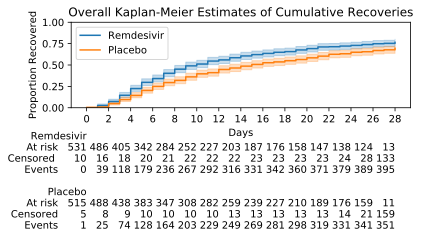

In [18]:
ix = data["TRTP"] == "Placebo"

ax = plt.subplot(111)

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(
    data.loc[~ix]["TTRECOV"],
    (1 - data.loc[~ix]["RECCNSR"]),
    label="Remdesivir",
    timeline=range(0, 29),
).plot_cumulative_density(ax=ax)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(
    data.loc[ix]["TTRECOV"],
    (1 - data.loc[ix]["RECCNSR"]),
    label="Placebo",
    timeline=range(0, 29),
).plot_cumulative_density(ax=ax)
ax.set_title("Overall Kaplan-Meier Estimates of Cumulative Recoveries")
ax.set_xlabel("Days", fontsize=10)
ax.set_ylabel("Proportion Recovered", fontsize=10)
ax.xaxis.set_ticks(np.arange(0, 29, 2))
ax.set_ylim(0, 1)

from lifelines.plotting import add_at_risk_counts

#add_at_risk_counts(kmf_exp, kmf_control, ax=ax, rows_to_show=['At risk'])
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

### 2. Kaplan–Meier Estimates (and 95% confidence bands) of Cumulative Recoveries by Baseline Ordinal Scale
Panel A shows the estimates (and 95% confidence bands) in the population with baseline ordinal scale = 4; 
Panel B in those with baseline ordinal scale = 5;
Panel C in those with baseline ordinal scale = 6; 
Panel D in those with baseline ordinal scale = 7.

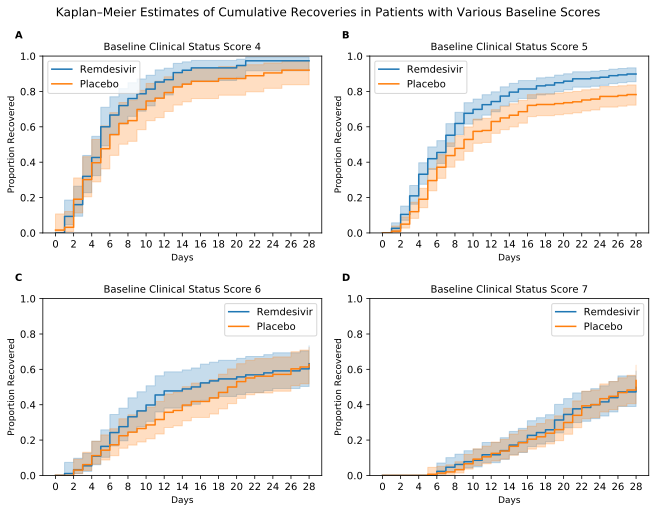

In [17]:
group1 = data[data["TRTP"] == "Remdesivir"]
group2 = data[data["TRTP"] == "Placebo"]
T = group1["TTRECOV"]
E = group1["RECCNSR"]
T1 = group2["TTRECOV"]
E1 = group2["RECCNSR"]

clinical_status_list = [x for x in data["ORDSCRG"].unique().tolist() if str(x) != "nan"]
clinical_status_list.sort()
fig, axes = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True)
fig.suptitle(
    "Kaplan–Meier Estimates of Cumulative Recoveries in Patients with Various Baseline Scores",
    fontsize=12,
)
axes = axes.reshape(4,)

for i, clinical_status in enumerate(clinical_status_list):

    ix = data["ORDSCRG"] == clinical_status
    kmf_control = KaplanMeierFitter()
    kmf_exp = KaplanMeierFitter()
    ax = kmf_exp.fit(
        T[ix], (1 - E[ix]), label="Remdesivir", timeline=range(0, 29)
    ).plot_cumulative_density(ax=axes[i])
    ax = kmf_control.fit(
        T1[ix], (1 - E1[ix]), label="Placebo", timeline=range(0, 29)
    ).plot_cumulative_density(ax=axes[i])
    ax.set_title(clinical_status, fontsize=10)
    ax.set_xlabel("Days", fontsize=9)
    ax.set_ylabel("Proportion Recovered", fontsize=9)
    ax.xaxis.set_ticks(np.arange(0, 29, 2))
    ax.set_ylim(0, 1)
    ax.text(
        -0.1,
        1.1,
        string.ascii_uppercase[i],
        transform=ax.transAxes,
        size=10,
        weight="bold",
    )

#### Summary of findings:
Patients in the remdesivir group had a shorter time to recovery than patients in the placebo group. 

## Stratified Cox Proportional Hazards Model to Estimate Time to Recovery According to Subgroup
Cox Proportional Hazards Model is a semi-parametric model in the sense that the baseline hazard function does not have to be specified i.e it can vary, allowing a different parameter to be used for each unique survival time. But, it assumes that the rate ratio remains proportional throughout the studied period. This results in increased flexibility of the model. A fully-parametric proportional hazards model also assumes that the baseline hazard function can be parameterized according to a particular model for the distribution of the survival times.

Here we calculate the hazard ratios using the stratified Cox model. Run the following cell to fit the Cox Proportional Hazards model using the `lifelines` package.


Data Wrangling:

In [6]:
di_race = {
    "WHITE": "White",
    "BLACK OR AFRICAN AMERICAN": "Black",
    "ASIAN": "Asian",
    "UNKNOWN": "Other",
    "AMERICAN INDIAN OR ALASKA NATIVE": "Other",
    "MULTIPLE": "Other",
    "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER": "Other",
}
di_ethnic = {
    "HISPANIC OR LATINO": "Hispanic or Latino",
    "NOT HISPANIC OR LATINO": "Not Hispanic or Latino",
    "UNKNOWN": "Unknown",
    "NOT REPORTED": "Unknown",
}
di_sex = {"M": "Male", "F": "Female"}

data1 = data.replace({"RACE": di_race, "ETHNIC": di_ethnic, "SEX": di_sex})
age_category = pd.cut(
    data1.AGE, bins=[18, 40, 65, 95], labels=["18 to <40 yr", "40 to <65 yr", "≥65 yr"]
)
data1["AGE"] = age_category

symp_category = pd.cut(
    data1.BDURSYMP, bins=[0, 10, 46], labels=["≤10 days", ">10 days"]
)
symp_category = symp_category.cat.add_categories(["Unknown"])
data1["BDURSYMP"] = symp_category
data1.loc[data1["BDURSYMP"].isnull() == True, "BDURSYMP"] = "Unknown"

model_expr = "TTRECOV ~  STRATUM + TTRECOV + C(REGION) + C(RACE) + C(ETHNIC) + C(AGE) + C(SEX) + C(BDURSYMP) + C(ORDSCRG) + RECCNSR"

y, X = dmatrices(model_expr, data1, return_type="dataframe")
X = X[X.columns.drop(list(X.filter(regex="Unknown")))]
X.head()

,Intercept,STRATUM[T.Severe Disease],C(REGION)[T.Europe],C(REGION)[T.North America],C(RACE)[T.Black],C(RACE)[T.Other],C(RACE)[T.White],C(ETHNIC)[T.Not Hispanic or Latino],C(AGE)[T.40 to <65 yr],C(AGE)[T.≥65 yr],C(SEX)[T.Male],C(BDURSYMP)[T.>10 days],C(ORDSCRG)[T.Baseline Clinical Status Score 5],C(ORDSCRG)[T.Baseline Clinical Status Score 6],C(ORDSCRG)[T.Baseline Clinical Status Score 7],TTRECOV,RECCNSR
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,6.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,25.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,0.0


Create Model and fit the data to train the model:

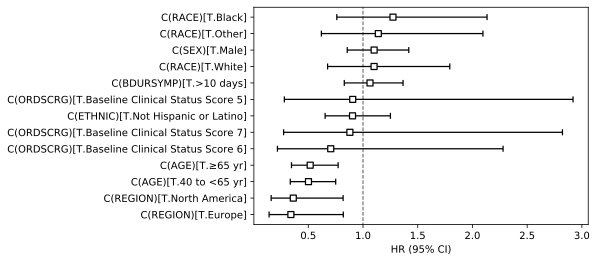

In [7]:
cph = CoxPHFitter()
cph.fit(
    df=X,
    duration_col="TTRECOV",
    event_col="RECCNSR",
    strata=["STRATUM[T.Severe Disease]"],
)
# Plot the HR
cph.plot(hazard_ratios=True)

In [8]:
# Have a look at the significance of the features
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1051 total observations, 751 right-censored observations>
             duration col = 'TTRECOV'
                event col = 'RECCNSR'
                   strata = ['STRATUM[T.Severe Disease]']
      baseline estimation = breslow
   number of observations = 1051
number of events observed = 300
   partial log-likelihood = -1456.67
         time fit was run = 2021-02-04 23:36:57 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                              
C(REGION)[T.Europe]                             -1.08       0.34       0.45            -1.95            -0.20                 0.14                 0.82
C(REGION)[T.North America]                      -1.01       0.36       0.41            -1.83            -0.20                 0.16                 0.82
C(RACE)[T.Black]                                 0.24       1.27       0.26            -0.27             0.76                 0.76                 2.13
C(RACE)[T.Other]                                 0.13       1.14       0.31            -0.48             0.74                 0.62                 2.10
C(RACE)[T.White]                                 0.10       1.10       0.25            -0.39             0.58                 0.68                 1.79
C(ETHNIC)[T.Not Hispanic or Latino]             -0.10       0.90       0.17            -0.42             0.22                 0.65                 1.25
C(AGE)[T.40 to <65 yr]                          -0.69       0.50       0.21            -1.09            -0.29                 0.34                 0.75
C(AGE)[T.≥65 yr]                                -0.66       0.52       0.20            -1.06            -0.26                 0.35                 0.77
C(SEX)[T.Male]                                   0.10       1.10       0.13            -0.16             0.35                 0.86                 1.42
C(BDURSYMP)[T.>10 days]                          0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
C(ORDSCRG)[T.Baseline Clinical Status Score 5]  -0.10       0.91       0.60            -1.27             1.07                 0.28                 2.92
C(ORDSCRG)[T.Baseline Clinical Status Score 6]  -0.35       0.71       0.60            -1.52             0.82                 0.22                 2.28
C(ORDSCRG)[T.Baseline Clinical Status Score 7]  -0.13       0.88       0.59            -1.29             1.04                 0.27                 2.82

                                                   z      p   -log2(p)
covariate                                                             
C(REGION)[T.Europe]                            -2.40   0.02       5.94
C(REGION)[T.North America]                     -2.44   0.01       6.10
C(RACE)[T.Black]                                0.92   0.36       1.48
C(RACE)[T.Other]                                0.42   0.67       0.57
C(RACE)[T.White]                                0.39   0.70       0.52
C(ETHNIC)[T.Not Hispanic or Latino]            -0.61   0.54       0.88
C(AGE)[T.40 to <65 yr]                         -3.36 <0.005      10.31
C(AGE)[T.≥65 yr]                               -3.22 <0.005       9.61
C(SEX)[T.Male]                                  0.75   0.45       1.15
C(BDURSYMP)[T.>10 days]                         0.49   0.63       0.68
C(ORDSCRG)[T.Baseline Clinical Status Score 5] -0.17   0.87       0.20
C(ORDSCRG)[T.Baseline Clinical Status Score 6] -0.58   0.56       0.84
C(ORDSCRG)[T.Baseline Clinical Status Score 7] -0.21   0.83       0.27
---
Concordance = 0.56
Partial AIC = 2939.33
log-likelihood ratio test = 19.88 on 13 df
-log2(p) of ll-ratio test = 3.35

### Summary
This notebook replicates the analysis in a recently published randomized comparative trial evaluating remdesivir treatment for COVID-19. In the workspace of NIAID Clinical Trials Data Commons, researchers can apply the commonly used survival analysis techniques, such as the Kaplan–Meier method, Cox model, hazard ratio method, etc. Clinical investigators are encouraged to consider applying these methods for quantifying treatment effects in future studies of COVID-19 using NIAID Clinical Trials Data Commons.